# 0. Import libraries
## 0.1. Import public libraries

In [51]:
import os
import sys

import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns


This notebook was made with celloracle version 0.6.9.
Please use celloracle>=0.6.9. Otherwise you may get an error.

In [52]:
import celloracle as co
co.__version__

'0.6.16'

In [53]:
#plt.rcParams["font.family"] = "arial"
plt.rcParams["figure.figsize"] = [6,6]
%config InlineBackend.figure_format = 'retina'
plt.rcParams["savefig.dpi"] = 600

%matplotlib inline

## 0.1. Make a folder to save graph

In [4]:
# Make folder to save plots
save_folder = "figures"
os.makedirs(save_folder, exist_ok=True)

# 1. Load data
## 1.1. Load processed oracle object

Load the oracle object. See the previous notebook for the notes on how to prepare the oracle object.

In [5]:
# oracle = co.load_hdf5("ORACLE OBJECT PATH")

# Here, we load tutorial oracle object. 
oracle = co.data.load_tutorial_oracle_object()
oracle

Oracle object

Meta data
    celloracle version used for instantiation: 0.6.11
    n_cells: 2671
    n_genes: 1999
    cluster_name: louvain_annot
    dimensional_reduction_name: X_draw_graph_fa
    n_target_genes_in_TFdict: 21259 genes
    n_regulatory_in_TFdict: 1093 genes
    n_regulatory_in_both_TFdict_and_scRNA-seq: 90 genes
    n_target_genes_both_TFdict_and_scRNA-seq: 1850 genes
    k_for_knn_imputation: 66
Status
    Gene expression matrix: Ready
    BaseGRN: Ready
    PCA calculation: Done
    Knn imputation: Done
    GRN calculation for simulation: Not finished

## 1.2. Load inferred GRNs

In the previous notebook, we calculated GRNs. Now, we will use these GRNs for simulation.
We import GRNs which were saved in the Links object.


In [7]:
# links = co.load_hdf5("YOUR LINK OBJCT PATH")

# Here, we load links object for tutorial.
links = co.data.load_tutorial_links_object()

# 2. Make predictive models for simulation

We will fit ridge regression models again.
This process takes less time than the GRN inference in the previous notebook because we only use significant TFs to predict target gene instead of all regulatory candidate TFs. 

In [8]:
links.filter_links()
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(alpha=10, use_cluster_specific_TFdict=True)

fitting GRN again...
calculating GRN in Ery_0



genes_in_gem: 1999
models made for 1085 genes
calculating GRN in Ery_1



genes_in_gem: 1999
models made for 1073 genes
calculating GRN in Ery_2



genes_in_gem: 1999
models made for 1070 genes
calculating GRN in Ery_3



genes_in_gem: 1999
models made for 1086 genes
calculating GRN in Ery_4



genes_in_gem: 1999
models made for 1087 genes
calculating GRN in Ery_5



genes_in_gem: 1999
models made for 1146 genes
calculating GRN in Ery_6



genes_in_gem: 1999
models made for 1095 genes
calculating GRN in Ery_7



genes_in_gem: 1999
models made for 1061 genes
calculating GRN in Ery_8



genes_in_gem: 1999
models made for 1109 genes
calculating GRN in Ery_9



genes_in_gem: 1999
models made for 1111 genes
calculating GRN in GMP_0



genes_in_gem: 1999
models made for 1094 genes
calculating GRN in GMP_1



genes_in_gem: 1999
models made for 1110 genes
calculating GRN in GMP_2



genes_in_gem: 1999
models made for 1106 genes
calculating GRN in GMPl_0



genes_in_gem: 1999
models made for 1082 genes
calculating GRN in GMPl_1



genes_in_gem: 1999
models made for 1089 genes
calculating GRN in Gran_0



genes_in_gem: 1999
models made for 1059 genes
calculating GRN in Gran_1



genes_in_gem: 1999
models made for 1075 genes
calculating GRN in Gran_2



genes_in_gem: 1999
models made for 1102 genes
calculating GRN in Gran_3



genes_in_gem: 1999
models made for 1191 genes
calculating GRN in MEP_0



genes_in_gem: 1999
models made for 1142 genes
calculating GRN in Mk_0



genes_in_gem: 1999
models made for 1104 genes
calculating GRN in Mo_0



genes_in_gem: 1999
models made for 1087 genes
calculating GRN in Mo_1



genes_in_gem: 1999
models made for 1112 genes
calculating GRN in Mo_2



genes_in_gem: 1999
models made for 1076 genes


# 3. in silico TF Perturbation analysis

Next, we will simulate  the effects of perturbing a single TF to investigate its function and regulatory mechanism.
See the celloracle paper for the details and scientific premise on the algorithm.


In this notebook, we'll show an example of the simulation; we'll simulate knock-out of  Gata1 gene in the hematopoiesis. 

Previous studies have shown that Gata1 is one of the TFs that regulates cell fate decisions in myeloid progenitors. Additionally, Gata1 has been shown to affect erythroid cell differentiation. 

Here, we will analyze Gata1 for the demonstration of celloracle; Celloracle try to recapitulate the previous findings of Gata1 gene above.

## 3.1. Check gene expression pattern.

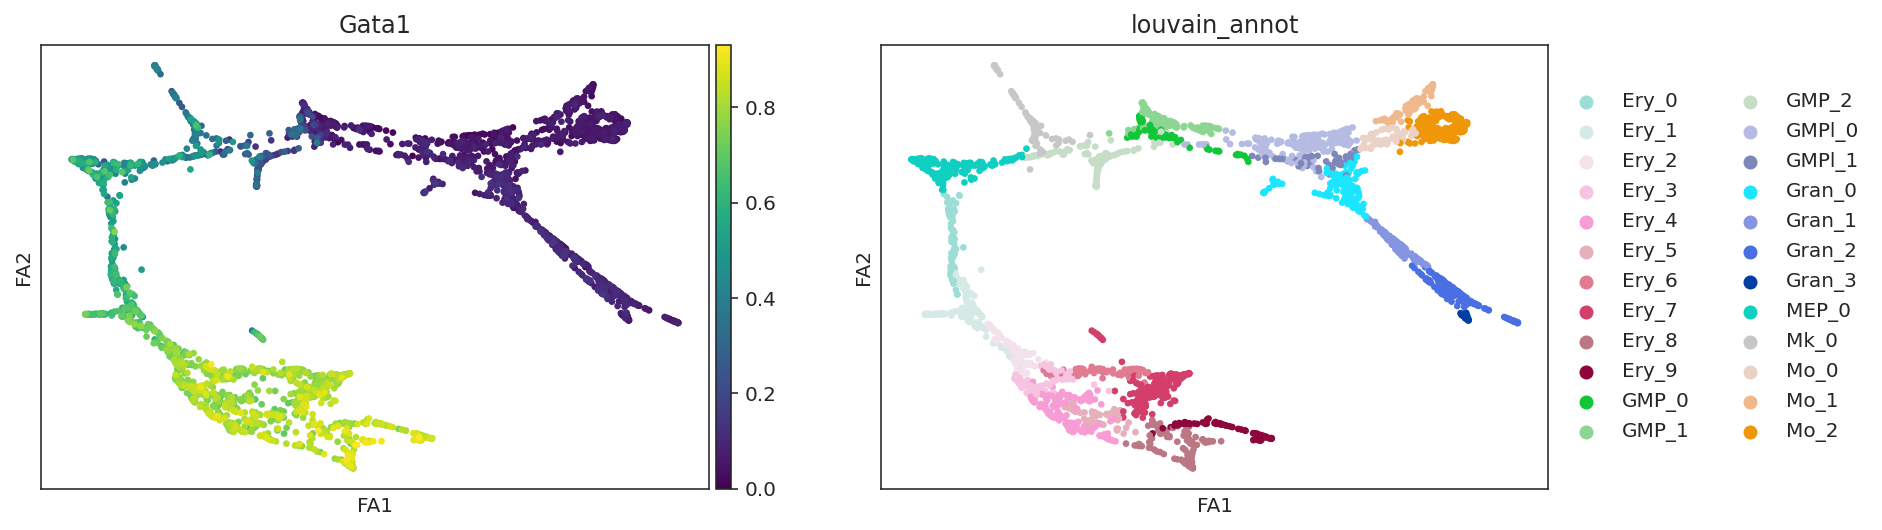

In [47]:
# Check gene expression 
goi = "Gata1"
sc.pl.draw_graph(oracle.adata, color=[goi, oracle.cluster_column_name],
                 layer="imputed_count", use_raw=False, cmap="viridis")

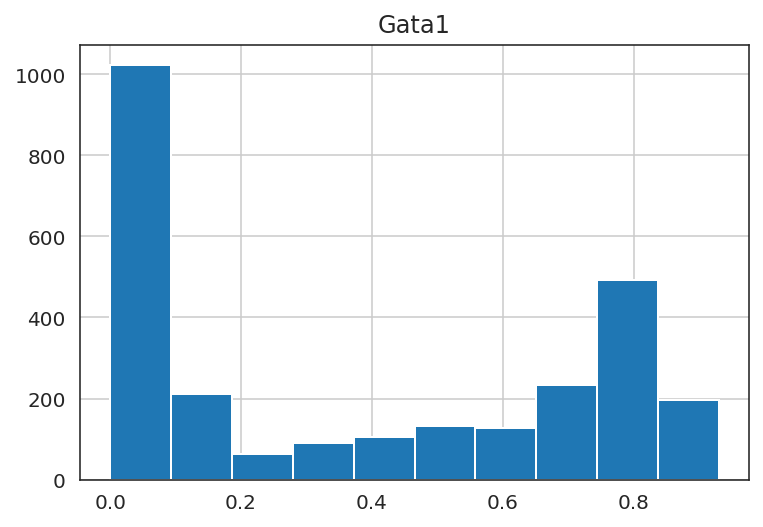

In [48]:
# Plot gene expression in histogram
sc.get.obs_df(oracle.adata, keys=[goi], layer="imputed_count").hist()
plt.show()

## 3.2. calculate future gene expression after perturbation.

- You can use any gene expression value to enter in silico perturbations, but avoid extremely high values that are far from the natural gene expression range. The upper limit allowed is twice the maximum gene expression.


Here we simulate Gata1 KO; we predict what happens to the cells if Gata1 gene expression changed into 0.

In [11]:
# Enter perturbation conditions to simulate signal propagation after the perturbation.
oracle.simulate_shift(perturb_condition={goi: 0.0},
                      n_propagation=3)

Variability score of Gene Gata1 is too low. Simulation accuracy may be poor with this gene.


## 3.3. calculate transition probability between cells

- The steps above simulated global future gene expression shift values after perturbation. This prediction is based on iterative calculations of signal propagation within the GRN. Please look at our paper for more information.

- The next step is to calculate the probability of cell state transitions based on the simulation data. You can use the transition probabilities between cells to predict how cells will change after a perturbation.

- This transition probability will be used later.


In [12]:
# Get transition probability
oracle.estimate_transition_prob(n_neighbors=200,
                                knn_random=True, 
                                sampled_fraction=1)

# Calculate embedding 
oracle.calculate_embedding_shift(sigma_corr = 0.05)

# 4. Visualization
## 4.1. Quiver plot: Show the direction of cell transition at single cell resolution

### Caution: It is very important to find optimal sccale parameter.

- We need to adjust the `scale` parameter. Plesase seeks to find the optimal  `scale` parameter that provides good visualization.

- If you don't see any vector, you can try the smaller `scale` parameter to magnify vector length. However, if you see some vectors in the right panel, which is a randomized simulation, it means that the scale parameters are too small.


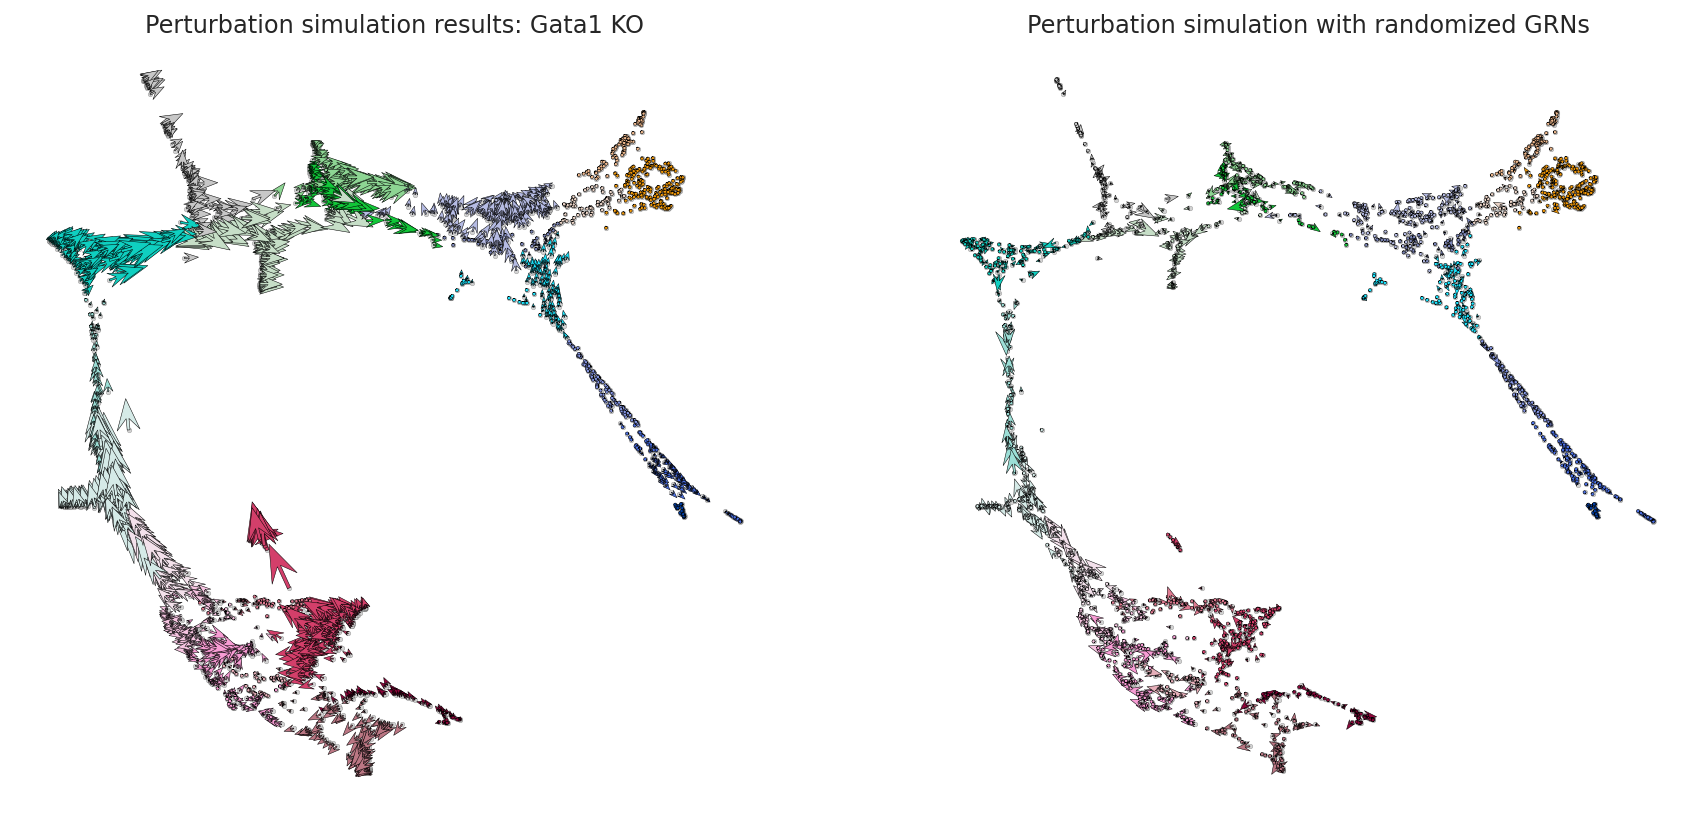

In [13]:
fig, ax = plt.subplots(1, 2,  figsize=[15, 7])

scale = 25
# Show quiver plot
oracle.plot_quiver(scale=scale, ax=ax[0])
ax[0].set_title(f"Perturbation simulation results: {goi} KO")

# Show quiver plot that was calculated with randomized GRN.
oracle.plot_quiver_random(scale=scale, ax=ax[1])
ax[1].set_title(f"Perturbation simulation with randomized GRNs")

plt.show()

## 4.2. Vector field graph

We can visualize simulation result as a vector field graph. Single cell transition vectors are grouped by grid point.

### 4.2.1  Find parameters for n_grid and min_mass
`n_grid`: Number of grid point.

`min_mass`: Threshold value for the cell density
The appropriate values for these parameters depends on the data. Please find appropriate values as follows.
 


In [31]:
# n_grid = 40 is a good point to start with.
n_grid = 40 
oracle.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=200)

Please run `oracle.suggest_mass_thresholds()`to find appropriate `min_mass` parameter.
It will give you some examples.

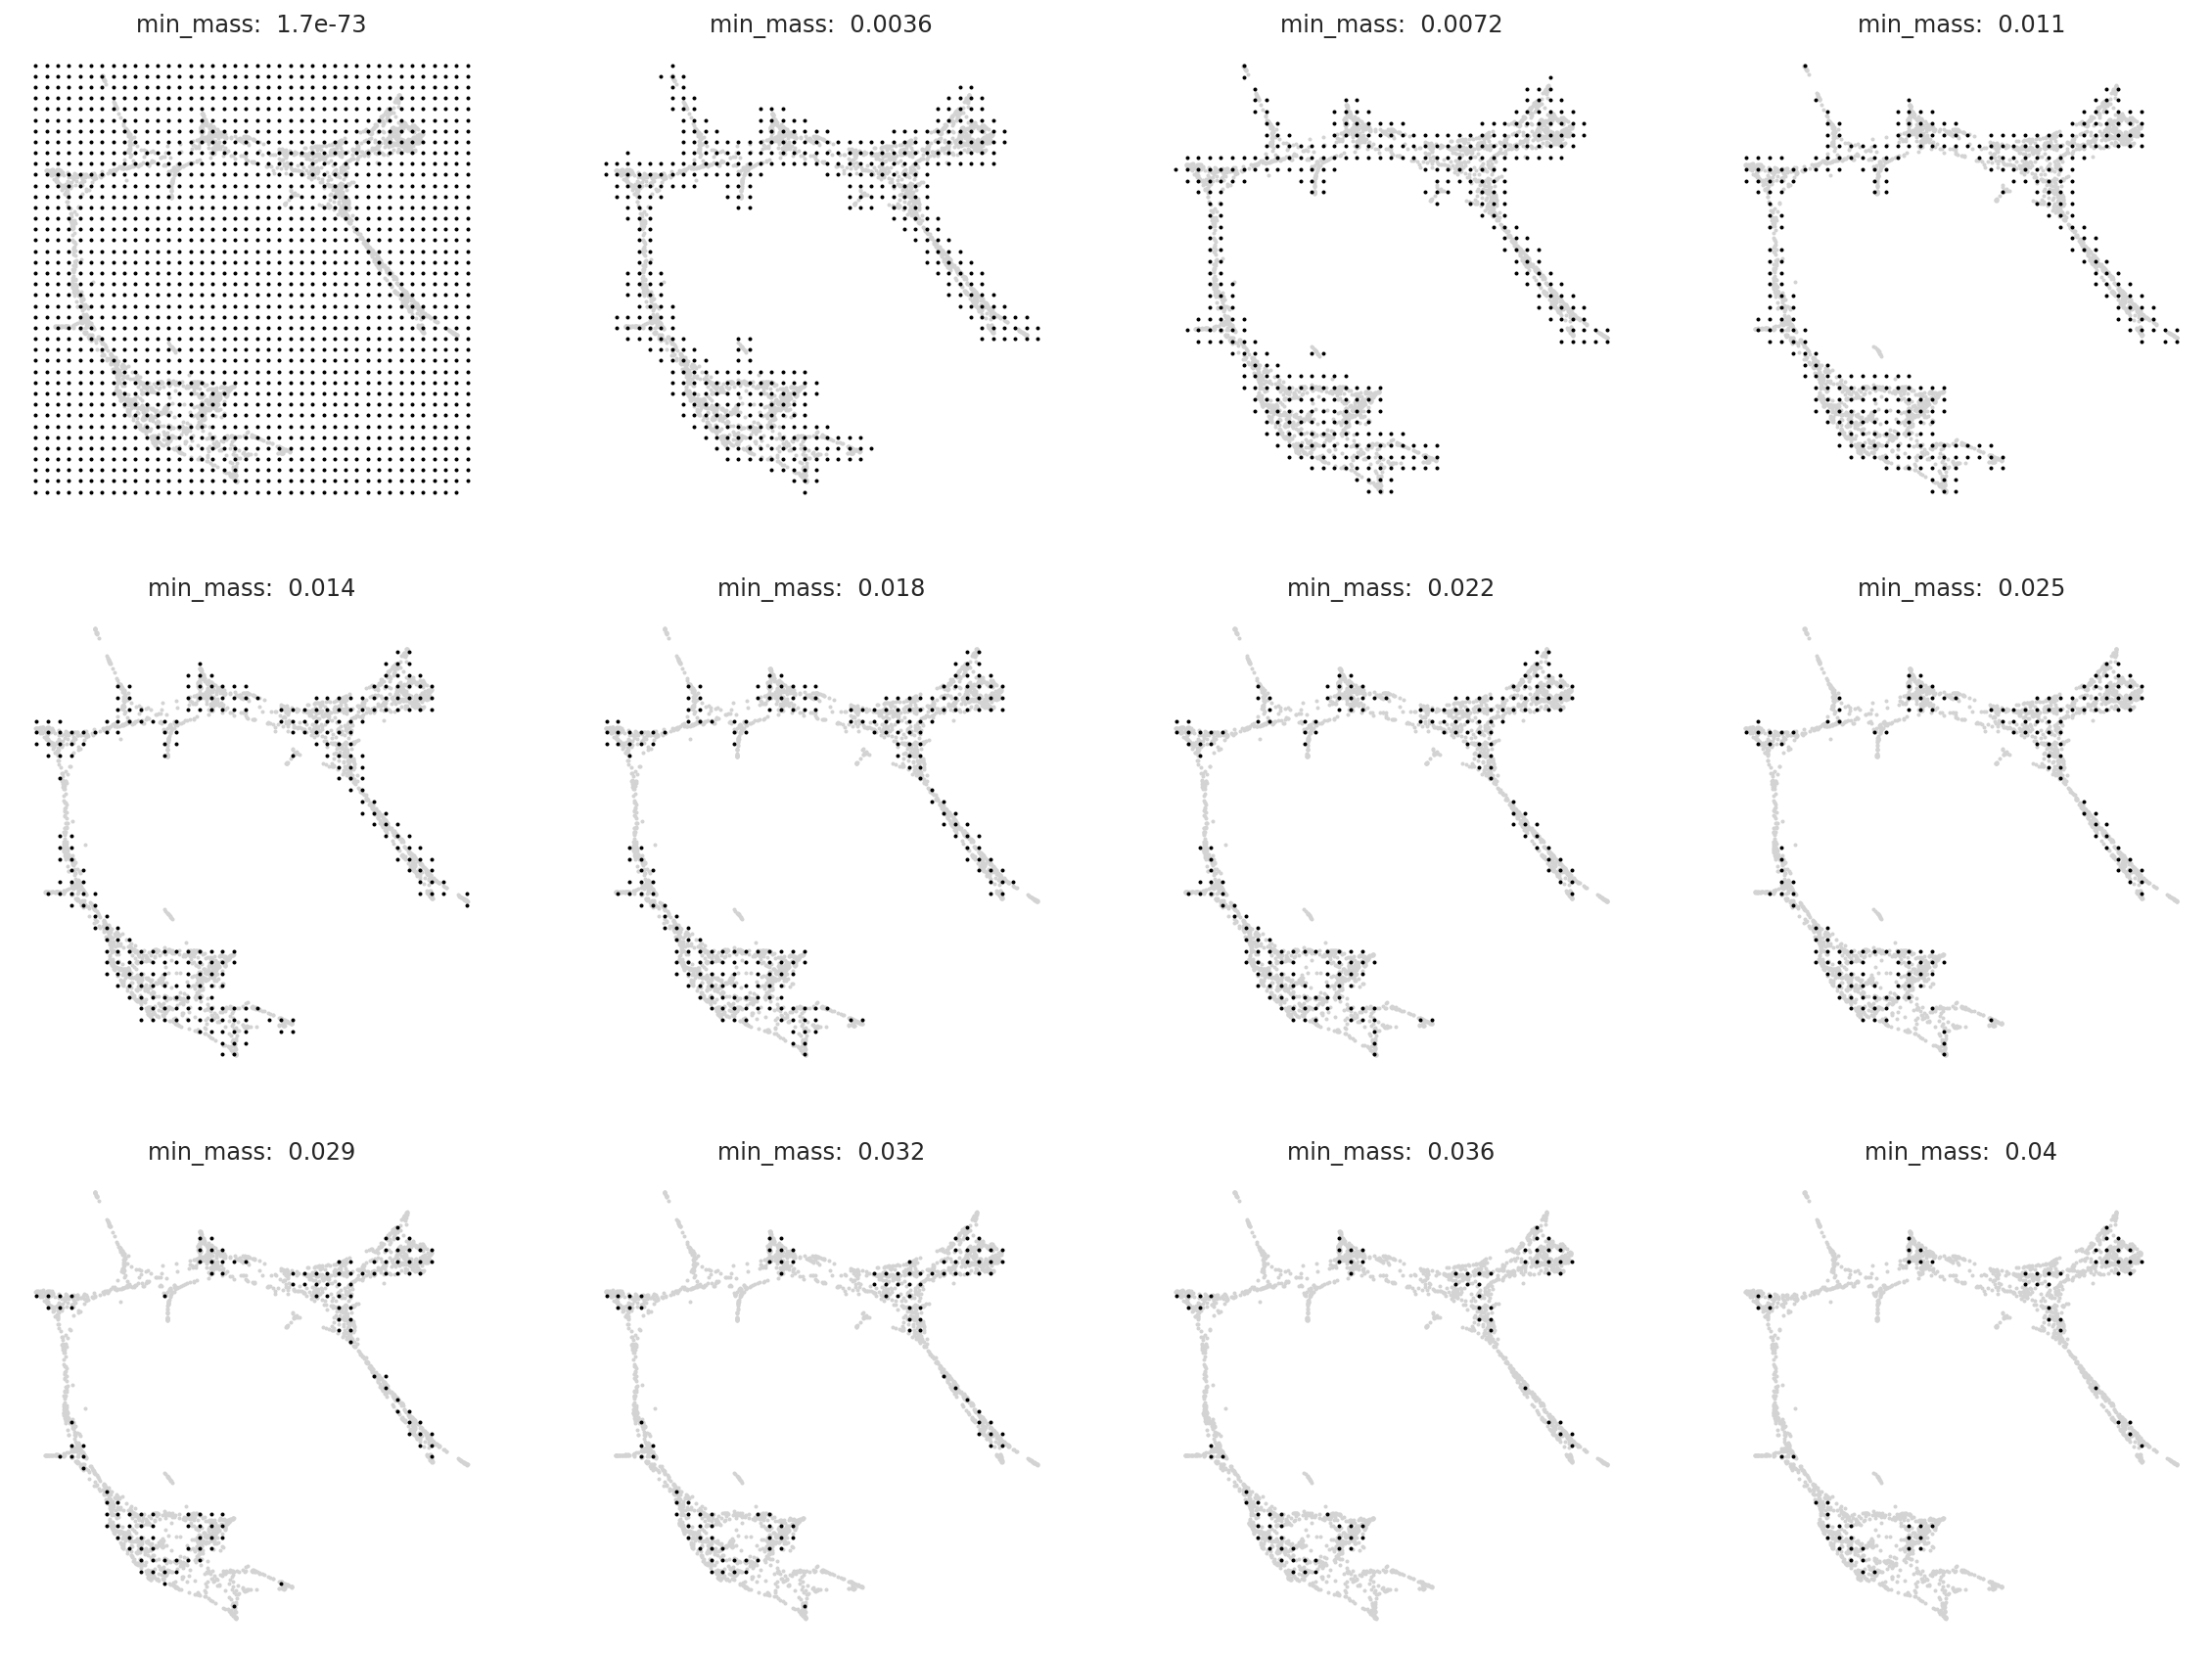

In [32]:
# Search for best min_mass.
oracle.suggest_mass_thresholds(n_suggestion=12)

According to the results, the appropriate `min_mass` is around 0.011.

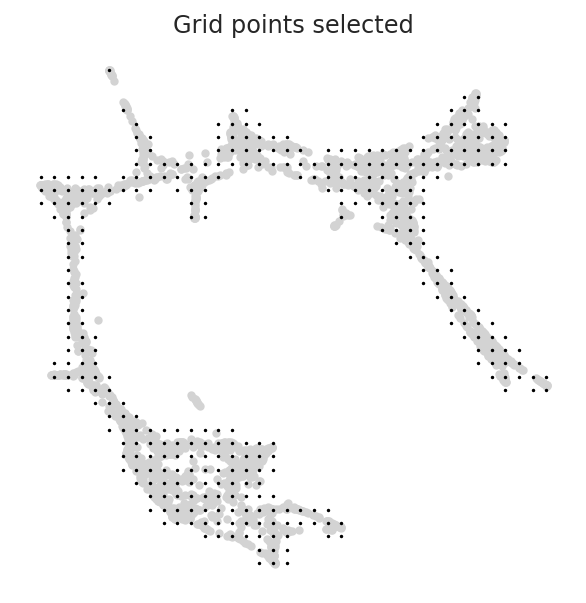

In [33]:
min_mass = 0.01
oracle.calculate_mass_filter(min_mass=min_mass, plot=True)

### 4.2.2  Plot vector fields

- Again, we need to adjust the `scale` parameter. Plesase seeks to find the optimal  `scale` parameter that provides good visualization.

- If you don't see any vector, you can try the smaller `scale` parameter to magnify vector length. However, if you see some vectors in the right panel, which is a randomized simulation, it means that the scale parameters are too small.



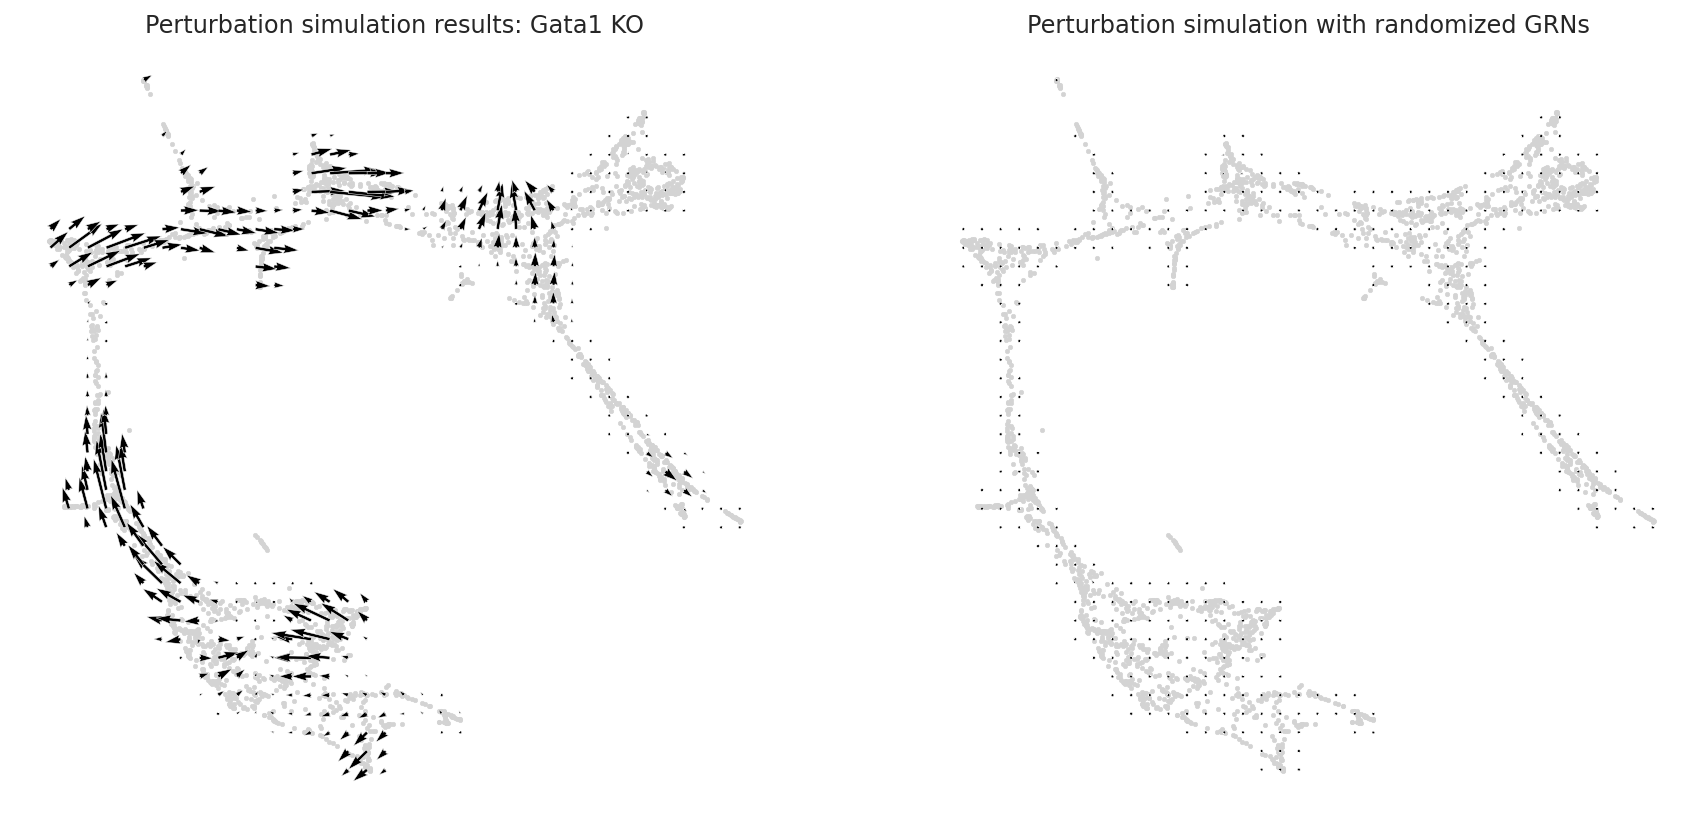

In [17]:
fig, ax = plt.subplots(1, 2,  figsize=[15, 7])

scale_grid = 0.5
# Show quiver plot
oracle.plot_simulation_flow_on_grid(scale=scale_grid, ax=ax[0])
ax[0].set_title(f"Perturbation simulation results: {goi} KO")

# Show quiver plot that was calculated with randomized GRN.
oracle.plot_simulation_flow_random_on_grid(scale=scale_grid, ax=ax[1])
ax[1].set_title(f"Perturbation simulation with randomized GRNs")

plt.show()

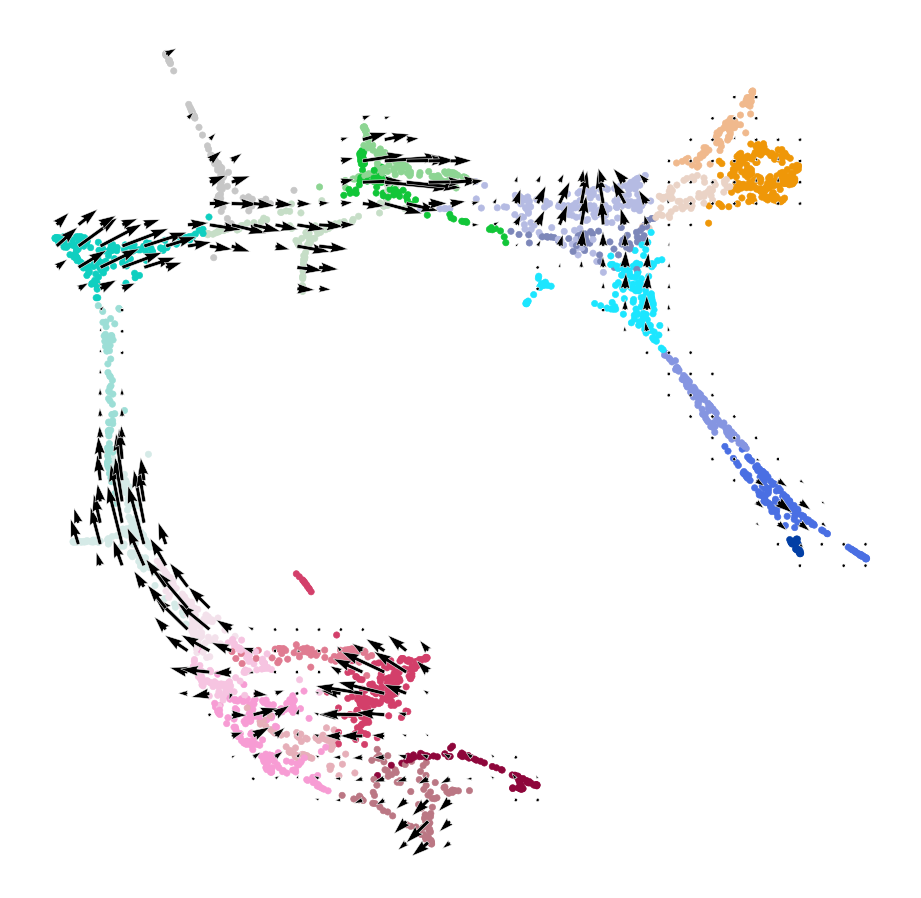

In [34]:
# Plot vector field with cell cluster 
fig, ax = plt.subplots(figsize=[8, 8])

oracle.plot_cluster_whole(ax=ax, s=10)
oracle.plot_simulation_flow_on_grid(scale=scale_grid, ax=ax, show_background=False)

# 5. Compare simulation vector with development vectors

## 5.0. Method overview

- As shown above, we can use celloracle's simulation to infer how TF perturbations affect cell identity. The simulation results are provided in the form of a vector field map.

- To interpret the results, it is necesary to take into account the directio of natiral differentiation. We will compare the simulated perturbation vectors with the development vecotor. By comparing them, we can intuitively understand how TF is involved in cell fate determination during development. This perspective is also important for the estimation of experimental perturbation results.

- Here, we show an example to calculate vector field of deveopment using pseudotime gradient. In short, the process is as follows.
 
 [Step 1] Transfer pseudotime data into n x n grid point.

 [Step 2] Calculate gradient of pseudotime to get vector field

 [Step 3] Compare in silico TF perturbation vector field with development vector field by calculating inner product between these two vector.


-  Also, there are many other options to get vector field of development flow from scRNA-seq data, and you can select another option. For example, RNA velocity analysis is a good way to estimate the direction of cell differentiation. Choose the method that best suits your data.



## 5.1. Check data

We use pseudotime data for an input of this analysis.
Pleas calculate continuous pseudotime in advance. Please look at another notebook for details on how to calculate pseudotime.

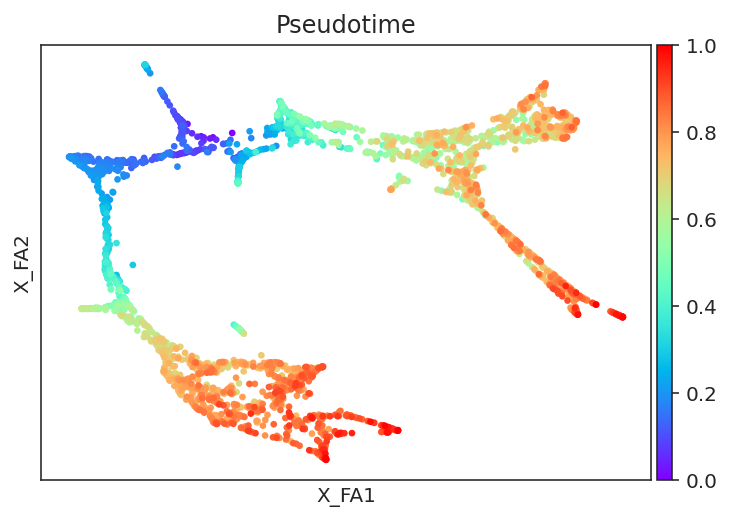

In [49]:
# Visualize pseudotime
fig, ax = plt.subplots(figsize=[6,6])

sc.pl.embedding(adata=oracle.adata, basis=oracle.embedding_name, ax=ax, cmap="rainbow",
                color=["Pseudotime"])

## 5.1. Make Gradient_calculator object

In [28]:
from celloracle.applications import Gradient_calculator

# Instantiate Gradient calculator object
gradient = Gradient_calculator(oracle_object=oracle, pseudotime_key="Pseudotime")

We need to select `n_grid` and `min_mass` to make grid point.
`n_grid`: Number of grid point.

We already know approproate values for them. Please set the same values as step 4.2.1 above.


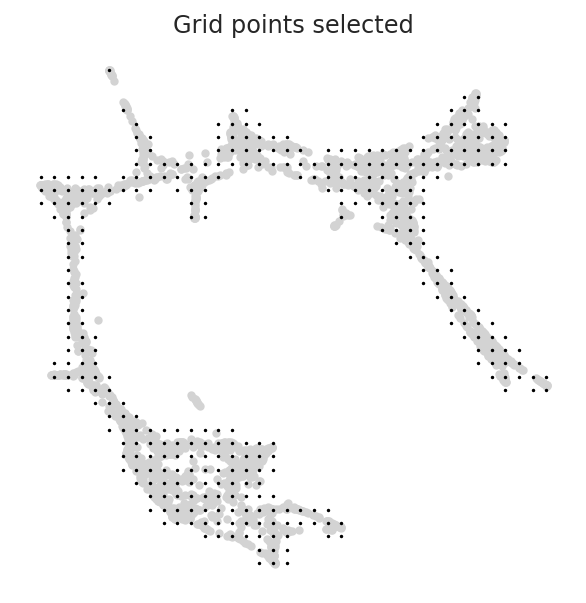

In [36]:
gradient.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=200)
gradient.calculate_mass_filter(min_mass=min_mass, plot=True)

## 5.2 Transfer pseudotime values to the grid points.

Next, we will transfer pseudotime data into grid points. For this calculation we can chose two method.

- knn: K-Nearesr Neighbor regressor. You need to set number of neighbor.
  Please adjust `n_knn` searching for best results.

 `gradient.transfer_data_into_grid(args={"method": "knn", "n_knn":50})`



- polynomial: Polynomial regression using x-axis and y-axis of dimensional reduction space.

 In general, this method will be more robust. Please use this method if k-nn does not work.
 `n_poly` is the number of degree for the polynomial regression model. Please try to find appropriate`n_poly` searching for best results.
 
 `gradient.transfer_data_into_grid(args={"method": "polynomial", "n_poly":3})`

2021-07-04 23:37:09,696 [20008] WARNING  py.warnings:99: [JupyterRequire] /home/k/anaconda3/envs/pandas1/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning:

Ill-conditioned matrix (rcond=1.11032e-17): result may not be accurate.




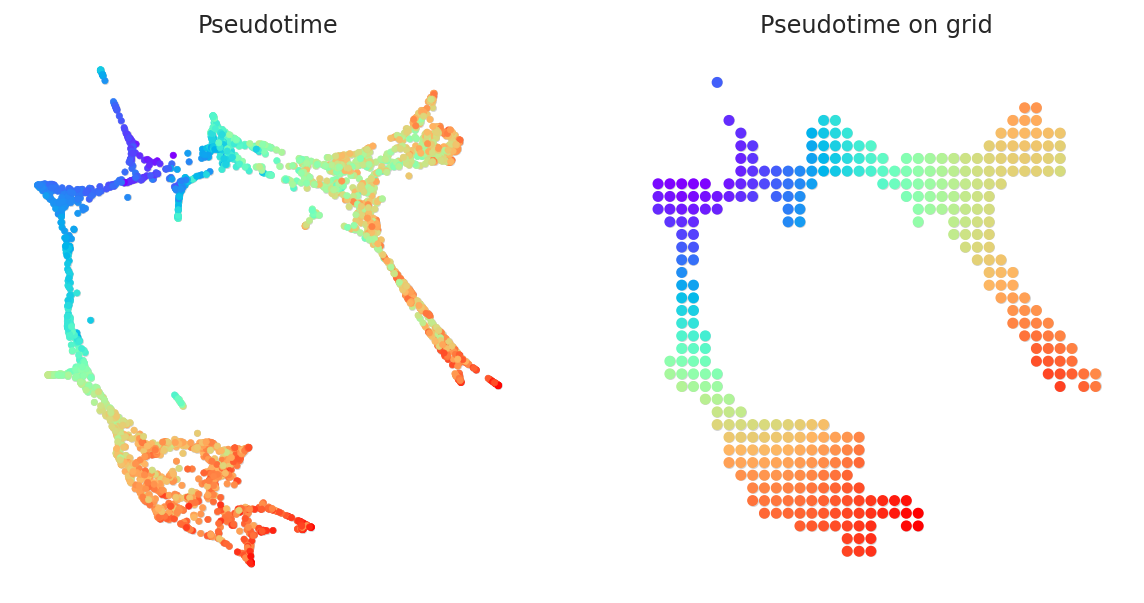

In [60]:
gradient.transfer_data_into_grid(args={"method": "polynomial", "n_poly":3}, plot=True)

## 5.3. Calculate Gradient vectors

Calculate 2D vector map that represents the gradient of pseudotime. After the gradient calculation, the length of the vector will be normalized automatically.

Please adjust `scale` parameter to adjust vector length.

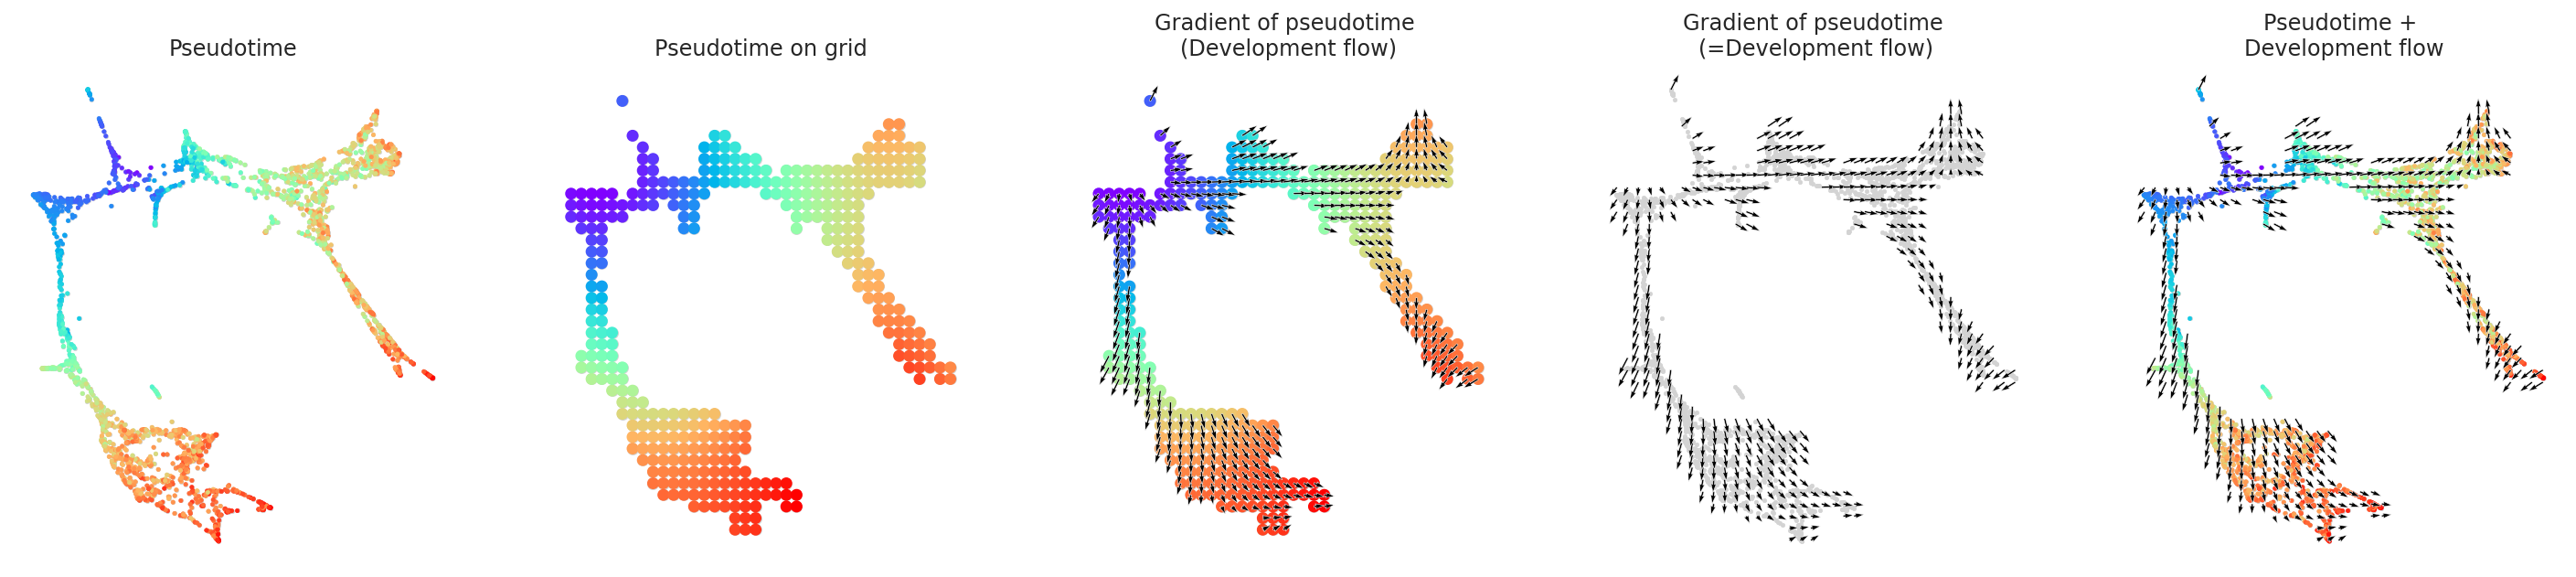

In [44]:
# Calculate graddient
gradient.calculate_gradient()

# Show results
scale = 30
gradient.visualize_results(scale=scale, s=5)

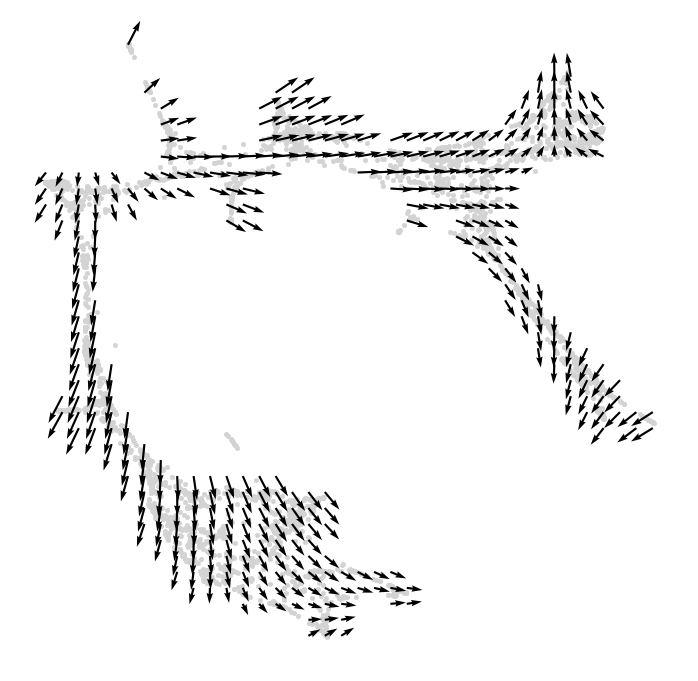

In [55]:
# Visualize results
fig, ax = plt.subplots(figsize=[6, 6])
gradient.plot_dev_flow_on_grid(scale=scale, ax=ax)

In [ ]:
# Save gradient object if you want.
#gradient.to_hdf5("../data/Paul_etal.celloracle.gradient")

## 5.4. Calculate Inner product between two vectors

We will use inner product to quantitatively compare the 2D vector map of perturb-simulation and development.
https://en.wikipedia.org/wiki/Dot_product

- Inner product represents similarity between two vectors. 

- Inner product will be calculated for the grid points to analze the similarity between the 2D vector map of perturbation simulation
and development flow. 

- Inner product score can be a positive value when two vectors are pointing in the same direction.
- Inner product score can be a negative value when two vectors are pointing in the opposite direction.

<img src="https://raw.githubusercontent.com/morris-lab/CellOracle/master/docs/demo_data/innerproduct_explantion_1.png">

- The length of vector also affects the absolute value of inner product score.

<img src="./innerproduct_explantion_2.png">

In summary, 
- **<span style="color: blue; "> a negative inner product</span>** means that perturbation might **<span style="color: blue; "> block differentiation </span>**.
- **<span style="color: red; "> a positive inner product</span>** means that perturbation might **<span style="color: red; "> promote differentiation </span>**.



In [61]:
from celloracle.applications import Oracle_development_module

# Make Oracle_development_module to compare two vector field
dev = Oracle_development_module()

# Load development flow
dev.load_differentiation_reference_data(gradient_object=gradient)

# Load simulation result
dev.load_perturb_simulation_data(oracle_object=oracle)


# Calculate inner produc scores
dev.calculate_inner_product()
dev.calculate_digitized_ip(n_bins=10)

# 5.5 Show results

Based on the results, we may conclude several things as follows.

Gata1 KO induced both cell state transitions from Erythroids to MEP, and from MEP to GMP.

(1) These results suggest that Gata1 may play a role in the progression of Erythroid differentiation and cell state determination between the MEP and GMP lineages.

(2) Gata1 KO also induced cell state transitions from granulocytes to late GMP, suggesting Gata1's involvement in Granulocytes differentiation.

These results agree with previous reports about Gata1 and recapitulate Gata1's cell-type-specific function regarding the cell fate decisions in hematopoiesis.